# Score de crédito 

## Bibliotecas


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from google.colab import files


## Função para gráficos 

In [ ]:
#Label in graphics

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## Importando dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Digio test/banco_de_dados_2.csv"
df = pd.read_csv(path,sep = ';')
df

,ID,SAFRA,CEP,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM
0,1,201907,92010190,37,M,400000,5280.0,7190.0,1
1,2,201909,65090650,36,M,195000,4540.0,7170.0,1
2,3,201908,13482783,43,F,12000,7560.0,8270.0,1
3,4,201905,60541704,35,M,12800,20.0,6070.0,0
4,5,201906,69086129,27,M,70580,5170.0,7380.0,0
...,...,...,...,...,...,...,...,...,...
6182,6183,201906,82900210,46,M,35000,5460.0,7030.0,1
6183,6184,201905,74070130,36,M,22000,7380.0,6700.0,1
6184,6185,201908,14060823,47,M,50000,8610.0,5500.0,0
6185,6186,201908,38408734,42,M,105000,5540.0,6530.0,1


## Análise Exploratória e Limpeza dos Dados

In [ ]:
df=df.iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6187 entries, 0 to 6186
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SAFRA     6187 non-null   int64  
 1   CEP       6187 non-null   int64  
 2   IDADE     6187 non-null   int64  
 3   GENERO    6162 non-null   object 
 4   RENDA     6187 non-null   int64  
 5   SCORE_F1  6184 non-null   float64
 6   SCORE_F2  6185 non-null   float64
 7   IND_BOM   6187 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 386.8+ KB


In [ ]:
#Quantidade de linhas
#df.shape[0]
len(df)

6187

In [ ]:
#Percentual de valores ausentes por colunas
((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)

GENERO      0.404073
SCORE_F1    0.048489
SCORE_F2    0.032326
IND_BOM     0.000000
RENDA       0.000000
IDADE       0.000000
CEP         0.000000
SAFRA       0.000000
dtype: float64

In [ ]:
#Quantidade de valores unicos por coluna
df.nunique().sort_values(ascending=True)

GENERO         2
IND_BOM        2
SAFRA          5
IDADE         60
SCORE_F2     448
SCORE_F1     563
RENDA       1124
CEP         5622
dtype: int64

Adimplente = 4439
Inadimplente = 1748


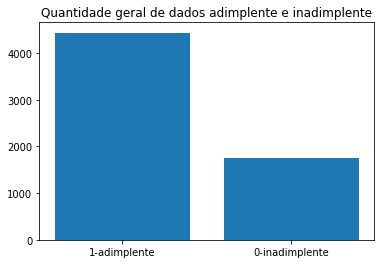

In [ ]:
df_ID_Bom = df[df['IND_BOM']== 1]
df_ID_Ruim = df[df['IND_BOM']== 0]

print("Adimplente =",len(df_ID_Bom))
print("Inadimplente =",len(df_ID_Ruim))
value=[len(df_ID_Bom),len(df_ID_Ruim)]
value_in_x=['1-adimplente','0-inadimplente']
plt.bar(value_in_x,value)
plt.title("Quantidade geral de dados adimplente e inadimplente")

plt.show()

In [ ]:
#método describe para mais informações sobre as variáveis numéricas.
df.describe()

,SAFRA,CEP,IDADE,RENDA,SCORE_F1,SCORE_F2,IND_BOM
count,6187.000000,6.187000e+03,6187.000000,6.187000e+03,6184.000000,6185.000000,6187.000000
mean,201907.226281,3.946375e+07,36.730726,6.101327e+04,5922.445019,6815.632983,0.717472
std,1.322369,3.192985e+07,16.259660,1.171864e+05,1916.713015,825.833867,0.450265
min,201905.000000,1.106070e+06,12.000000,9.980000e+03,20.000000,4110.000000,0.000000
25%,201906.000000,9.945891e+06,28.000000,2.200000e+04,4730.000000,6260.000000,0.000000
50%,201907.000000,2.904520e+07,35.000000,3.500000e+04,6080.000000,6810.000000,1.000000
75%,201908.000000,7.197891e+07,43.000000,5.500000e+04,7390.000000,7400.000000,1.000000
max,201909.000000,9.971311e+07,999.000000,2.745052e+06,9840.000000,9390.000000,1.000000


In [ ]:
#lidando com menores de idade
df['IDADE'].idxmax()
df_age_ = df[ df['IDADE'] < 18 ] # Step 1
df = df.drop(df_age_.index, axis=0)
df_age_2 = df[ df['IDADE'] > 200 ] # Step 1
df = df.drop(df_age_2.index, axis=0)
df['IDADE'].max()
df.describe()

,SAFRA,CEP,IDADE,RENDA,SCORE_F1,SCORE_F2,IND_BOM
count,6161.000000,6.161000e+03,6161.000000,6.161000e+03,6158.000000,6159.000000,6161.000000
mean,201907.225613,3.943965e+07,36.674890,6.105032e+04,5920.354011,6815.004059,0.717741
std,1.322655,3.191143e+07,10.615489,1.173897e+05,1916.115529,825.740525,0.450135
min,201905.000000,1.106070e+06,21.000000,9.980000e+03,20.000000,4110.000000,0.000000
25%,201906.000000,9.950580e+06,28.000000,2.200000e+04,4730.000000,6250.000000,0.000000
50%,201907.000000,2.904520e+07,35.000000,3.500000e+04,6075.000000,6810.000000,1.000000
75%,201908.000000,7.193936e+07,43.000000,5.500000e+04,7380.000000,7400.000000,1.000000
max,201909.000000,9.971311e+07,80.000000,2.745052e+06,9840.000000,9390.000000,1.000000


In [ ]:
#Lidando com os valores NULL 
df_GENERO_ = df[ df['GENERO'].isnull() ] # Step 1
df = df.drop(df_GENERO_.index, axis=0) # Step 2

df_SCORE_F1_ = df[ df['SCORE_F1'].isnull() ] # Step 1
df = df.drop(df_SCORE_F1_.index, axis=0) # Step 2

df_SCORE_F2_ = df[ df['SCORE_F2'].isnull() ] # Step 1
df = df.drop(df_SCORE_F2_.index, axis=0) # Step 2


((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)

IND_BOM     0.0
SCORE_F2    0.0
SCORE_F1    0.0
RENDA       0.0
GENERO      0.0
IDADE       0.0
CEP         0.0
SAFRA       0.0
dtype: float64

In [ ]:
df

,SAFRA,CEP,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM
0,201907,92010190,37,M,400000,5280.0,7190.0,1
1,201909,65090650,36,M,195000,4540.0,7170.0,1
2,201908,13482783,43,F,12000,7560.0,8270.0,1
3,201905,60541704,35,M,12800,20.0,6070.0,0
4,201906,69086129,27,M,70580,5170.0,7380.0,0
...,...,...,...,...,...,...,...,...
6182,201906,82900210,46,M,35000,5460.0,7030.0,1
6183,201905,74070130,36,M,22000,7380.0,6700.0,1
6184,201908,14060823,47,M,50000,8610.0,5500.0,0
6185,201908,38408734,42,M,105000,5540.0,6530.0,1


## Análises descritivas 

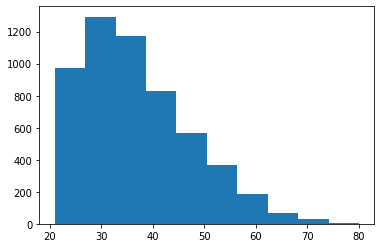

In [ ]:
plt.hist(x = df['IDADE']);

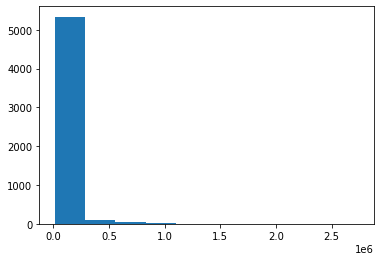

In [ ]:
plt.hist(x = df['RENDA']);

In [ ]:
import plotly.express as px

In [ ]:
grafico = px.scatter_matrix(df, dimensions=['IDADE', 'RENDA', 'GENERO'])
grafico.show()

mulheres de 13 a 19 anos: 0
homens de 13 a 19 anos: 0
mulheres de 20 a 39 anos: 1675
homens de 20 a 39 anos: 2361
mulheres de 40 a 64 anos: 813
homens de 40 a 64 anos: 1197
mulheres de 65 anos ou mais: 27
homens de 65 anos ou mais: 58
A difenca entre a quantidade de homens e mulheres e' de: 1101


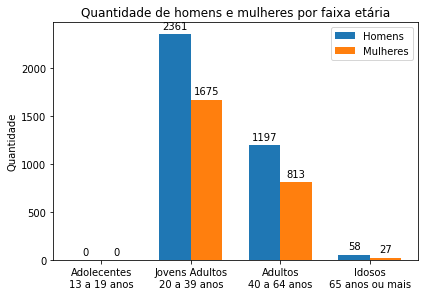

In [ ]:
#gender plots by age
#criando a segmentação de homens e mulheres

df_women = df[df['GENERO']=='F']
df_men = df[df['GENERO']=='M']


#mulheres 13 a 19 anos

df_women13_19 = df_women[df_women['IDADE'].astype(int) >= 13]
df_women13_19 = df_women13_19[df_women13_19['IDADE'].astype(int) <= 19]
n_teenager = len(df_women13_19)
print("mulheres de 13 a 19 anos:", n_teenager)

#homens 13 a 19 anos
df_men13_19 = df_men[df_men['IDADE'].astype(int) >= 13]
df_men13_19 = df_men13_19[df_men13_19['IDADE'].astype(int) <= 19]
m_teenager = len(df_men13_19)
print("homens de 13 a 19 anos:", m_teenager)

#mulheres 20 a 39 anos
df_women20_39 = df_women[df_women['IDADE'].astype(int) >= 20]
df_women20_39 = df_women20_39[df_women20_39['IDADE'].astype(int) <= 39]
n_yadult = len(df_women20_39)
print("mulheres de 20 a 39 anos:", n_yadult)

#homens 20 a 39 anos
df_men20_39 = df_men[df_men['IDADE'].astype(int) >= 20]
df_men20_39 = df_men20_39[df_men20_39['IDADE'].astype(int) <= 39]
m_yadult = len(df_men20_39)
print("homens de 20 a 39 anos:", m_yadult)

#mulheres 40 a 64 anos
df_women40_64 = df_women[df_women['IDADE'].astype(int) >= 40]
df_women40_64 = df_women40_64[df_women40_64['IDADE'].astype(int) <= 64]
n_adult = len(df_women40_64)
print("mulheres de 40 a 64 anos:", n_adult)

#homens 40 a 64 anos
df_men40_64 = df_men[df_men['IDADE'].astype(int) >= 40]
df_men40_64 = df_men40_64[df_men40_64['IDADE'].astype(int) <= 64]
m_adult = len(df_men40_64)
print("homens de 40 a 64 anos:", m_adult)

#mulheres 65+
df_women65 = df_women[df_women['IDADE'].astype(int) >= 65]
n_elderly = len(df_women65)
print("mulheres de 65 anos ou mais:", n_elderly)

#homens 65+
df_men65 = df_men[df_men['IDADE'].astype(int) >= 65]
m_elderly = len(df_men65)
print("homens de 65 anos ou mais:", m_elderly)


#plotando o gráfico
labels = ['Adolecentes\n13 a 19 anos', 'Jovens Adultos\n20 a 39 anos', 'Adultos\n40 a 64 anos', 'Idosos\n65 anos ou mais']
men_means = [m_teenager, m_yadult, m_adult, m_elderly]
women_means = [n_teenager, n_yadult, n_adult, n_elderly]
diffmen_women=(m_teenager+m_yadult+ m_adult+ m_elderly)-(n_teenager+ n_yadult+ n_adult+ n_elderly)
print("A difenca entre a quantidade de homens e mulheres e' de:",diffmen_women )

x = np.arange(len(labels))  
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Homens')
rects2 = ax.bar(x + width/2, women_means, width, label='Mulheres')
ax.set_ylabel('Quantidade')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
autolabel(rects1)
autolabel(rects2)
plt.title("Quantidade de homens e mulheres por faixa etária")
plt.show()


ID bom na faixa etária de 13 a 19 anos: 0
ID Ruim na faixa etária de 13 a 19 anos: 0
ID bom na faixa etária de 20 a 39 anos: 2840
ID Ruim na faixa etária de 20 a 39 anos: 1196
ID BOM entre 40 a 64 anos: 1486
ID ruim entre 40 a 64 anos: 524
ID bom na faixa de 65+ 73
ID ruim na faixa de 65+ 12


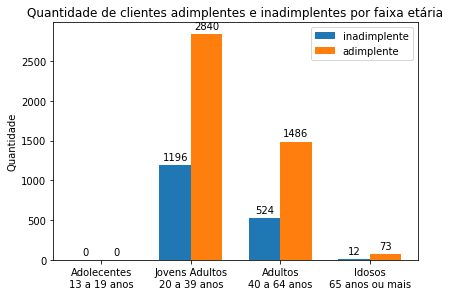

In [ ]:
#gender plots by age
#criando a segmentação de adimplente e inadimplente

df_ID_Bom = df[df['IND_BOM']== 1]
df_ID_Ruim = df[df['IND_BOM']== 0]


#ID bom 13 a 19 anos


df_ID_Bom13_19 = df_ID_Bom[df_ID_Bom['IDADE'].astype(int) >= 13]
df_ID_Bom13_19 = df_ID_Bom13_19[df_ID_Bom13_19['IDADE'].astype(int) <= 19]
n_teenager = len(df_ID_Bom13_19)
print("ID bom na faixa etária de 13 a 19 anos:", n_teenager)

#ID Ruim 13 a 19 anos
df_ID_Ruim13_19 = df_ID_Ruim[df_ID_Ruim['IDADE'].astype(int) >= 13]
df_ID_Ruim13_19 = df_ID_Ruim13_19[df_ID_Ruim13_19['IDADE'].astype(int) <= 19]
m_teenager = len(df_ID_Ruim13_19)
print("ID Ruim na faixa etária de 13 a 19 anos:", m_teenager)

#Id bom 20 a 39 anos
df_ID_Bom20_39 = df_ID_Bom[df_ID_Bom['IDADE'].astype(int) >= 20]
df_ID_Bom20_39 = df_ID_Bom20_39[df_ID_Bom20_39['IDADE'].astype(int) <= 39]
n_yadult = len(df_ID_Bom20_39)
print("ID bom na faixa etária de 20 a 39 anos:", n_yadult)

#ID ID Ruim entre 20 a 39 anos
df_ID_Ruim20_39 = df_ID_Ruim[df_ID_Ruim['IDADE'].astype(int) >= 20]
df_ID_Ruim20_39 = df_ID_Ruim20_39[df_ID_Ruim20_39['IDADE'].astype(int) <= 39]
m_yadult = len(df_ID_Ruim20_39)
print("ID Ruim na faixa etária de 20 a 39 anos:", m_yadult)

#ID BOM entre 40 a 64 anos
df_Id_Bom40_64 = df_ID_Bom[df_ID_Bom['IDADE'].astype(int) >= 40]
df_Id_Bom40_64 = df_Id_Bom40_64[df_Id_Bom40_64['IDADE'].astype(int) <= 64]
n_adult = len(df_Id_Bom40_64)
print("ID BOM entre 40 a 64 anos:", n_adult)

#ID ruim entre 40 a 64 anos
df_ID_Ruim40_64 = df_ID_Ruim[df_ID_Ruim['IDADE'].astype(int) >= 40]
df_ID_Ruim40_64 = df_ID_Ruim40_64[df_ID_Ruim40_64['IDADE'].astype(int) <= 64]
m_adult = len(df_ID_Ruim40_64)
print("ID ruim entre 40 a 64 anos:", m_adult)

#ID bom na faixa de 65+
df_ID_Bom65 = df_ID_Bom[df_ID_Bom['IDADE'].astype(int) >= 65]
n_elderly = len(df_ID_Bom65)
print("ID bom na faixa de 65+", n_elderly)

#ID ruim na faixa de 65+
df_ID_Ruim65 = df_ID_Ruim[df_ID_Ruim['IDADE'].astype(int) >= 65]
m_elderly = len(df_ID_Ruim65)
print("ID ruim na faixa de 65+", m_elderly)


#plotando o gráfico
labels = ['Adolecentes\n13 a 19 anos', 'Jovens Adultos\n20 a 39 anos', 'Adultos\n40 a 64 anos', 'Idosos\n65 anos ou mais']
IDRUIM_means = [m_teenager, m_yadult, m_adult, m_elderly]
IDBOM_means = [n_teenager, n_yadult, n_adult, n_elderly]

x = np.arange(len(labels))  
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, IDRUIM_means, width, label='inadimplente')
rects2 = ax.bar(x + width/2, IDBOM_means, width, label='adimplente')
ax.set_ylabel('Quantidade')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
autolabel(rects1)
autolabel(rects2)
plt.title("Quantidade de clientes adimplentes e inadimplentes por faixa etária")
plt.show()

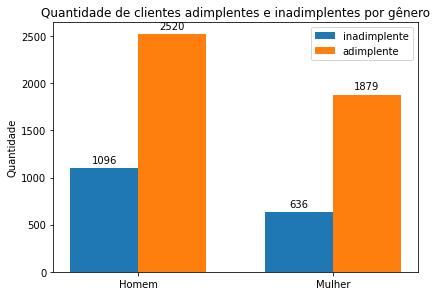

In [ ]:
#gender plots by age
#criando a segmentação de adimplente e inadimplente

df_ID_Bom = df[df['IND_BOM']== 1]
df_ID_Bom_mulher=df_ID_Bom[df_ID_Bom['GENERO']=='F']
df_ID_Bom_homem=df_ID_Bom[df_ID_Bom['GENERO']=='M']

df_ID_Ruim = df[df['IND_BOM']== 0]
df_ID_Ruim_mulher=df_ID_Ruim[df_ID_Ruim['GENERO']=='F']
df_ID_Ruim_homem=df_ID_Ruim[df_ID_Ruim['GENERO']=='M']

#plotando o gráfico
labels = ['Homem', 'Mulher']
IDRUIM_means = [len(df_ID_Ruim_homem), len(df_ID_Ruim_mulher)]
IDBOM_means = [len(df_ID_Bom_homem),len(df_ID_Bom_mulher)]


x = np.arange(len(labels))  
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, IDRUIM_means, width, label='inadimplente')
rects2 = ax.bar(x + width/2, IDBOM_means, width, label='adimplente')
ax.set_ylabel('Quantidade')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
autolabel(rects1)
autolabel(rects2)
plt.title("Quantidade de clientes adimplentes e inadimplentes por gênero")
plt.show()

## Trabalhando com o CEP

In [ ]:
#Deixando todos os ceps com 8 caracteres (SP capital inicia com zero)
df['CEP'] = df['CEP'].apply(str)
df['CEP'] = df['CEP'].apply(lambda x: x.zfill(8))


In [ ]:
df=df.iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6131 entries, 0 to 6186
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CEP       6131 non-null   object 
 1   IDADE     6131 non-null   int64  
 2   GENERO    6131 non-null   object 
 3   RENDA     6131 non-null   int64  
 4   SCORE_F1  6131 non-null   float64
 5   SCORE_F2  6131 non-null   float64
 6   IND_BOM   6131 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 383.2+ KB


In [ ]:
((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)

IND_BOM     0.0
SCORE_F2    0.0
SCORE_F1    0.0
RENDA       0.0
GENERO      0.0
IDADE       0.0
CEP         0.0
dtype: float64

![](https://drive.google.com/uc?export=view&id=1Urakpl8e_cNpZj8j-7KNmn-q3wgpcJMA)

In [ ]:
#criando as colunas de cada região para trabalhar com o cep
df['Regiao_0'] = 0
df['Regiao_1'] = 0
df['Regiao_2'] = 0
df['Regiao_3'] = 0
df['Regiao_4'] = 0
df['Regiao_5'] = 0
df['Regiao_6'] = 0
df['Regiao_7'] = 0
df['Regiao_8'] = 0
df['Regiao_9'] = 0

In [ ]:
df.columns

Index(['CEP', 'IDADE', 'GENERO', 'RENDA', 'SCORE_F1', 'SCORE_F2', 'IND_BOM',
       'Regiao_0', 'Regiao_1', 'Regiao_2', 'Regiao_3', 'Regiao_4', 'Regiao_5',
       'Regiao_6', 'Regiao_7', 'Regiao_8', 'Regiao_9'],
      dtype='object')

### Arrumando os ceps, criando uma meneira de colocar um peso nele 

In [ ]:
df['Regiao_0'] = list(map(lambda x: x.startswith('0'), df['CEP']))
df['Regiao_1'] = list(map(lambda x: x.startswith('1'), df['CEP']))
df['Regiao_2'] = list(map(lambda x: x.startswith('2'), df['CEP']))
df['Regiao_3'] = list(map(lambda x: x.startswith('3'), df['CEP']))
df['Regiao_4'] = list(map(lambda x: x.startswith('4'), df['CEP']))
df['Regiao_5'] = list(map(lambda x: x.startswith('5'), df['CEP']))
df['Regiao_6'] = list(map(lambda x: x.startswith('6'), df['CEP']))
df['Regiao_7'] = list(map(lambda x: x.startswith('7'), df['CEP']))
df['Regiao_8'] = list(map(lambda x: x.startswith('8'), df['CEP']))
df['Regiao_9'] = list(map(lambda x: x.startswith('9'), df['CEP']))
df

,CEP,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM,Regiao_0,Regiao_1,Regiao_2,Regiao_3,Regiao_4,Regiao_5,Regiao_6,Regiao_7,Regiao_8,Regiao_9
0,92010190,37,M,400000,5280.0,7190.0,1,False,False,False,False,False,False,False,False,False,True
1,65090650,36,M,195000,4540.0,7170.0,1,False,False,False,False,False,False,True,False,False,False
2,13482783,43,F,12000,7560.0,8270.0,1,False,True,False,False,False,False,False,False,False,False
3,60541704,35,M,12800,20.0,6070.0,0,False,False,False,False,False,False,True,False,False,False
4,69086129,27,M,70580,5170.0,7380.0,0,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,82900210,46,M,35000,5460.0,7030.0,1,False,False,False,False,False,False,False,False,True,False
6183,74070130,36,M,22000,7380.0,6700.0,1,False,False,False,False,False,False,False,True,False,False
6184,14060823,47,M,50000,8610.0,5500.0,0,False,True,False,False,False,False,False,False,False,False
6185,38408734,42,M,105000,5540.0,6530.0,1,False,False,False,True,False,False,False,False,False,False


In [ ]:
df['Regiao_0'] = df["Regiao_0"].astype(int)
df["Regiao_1"] = df["Regiao_1"].astype(int)
df["Regiao_2"] = df["Regiao_2"].astype(int)
df["Regiao_3"] = df["Regiao_3"].astype(int)
df["Regiao_4"] = df["Regiao_4"].astype(int)
df["Regiao_5"] = df["Regiao_5"].astype(int)
df["Regiao_6"] = df["Regiao_6"].astype(int)
df["Regiao_7"] = df["Regiao_7"].astype(int)
df["Regiao_8"] = df["Regiao_8"].astype(int)
df["Regiao_9"] = df["Regiao_9"].astype(int)
df

,CEP,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM,Regiao_0,Regiao_1,Regiao_2,Regiao_3,Regiao_4,Regiao_5,Regiao_6,Regiao_7,Regiao_8,Regiao_9
0,92010190,37,M,400000,5280.0,7190.0,1,0,0,0,0,0,0,0,0,0,1
1,65090650,36,M,195000,4540.0,7170.0,1,0,0,0,0,0,0,1,0,0,0
2,13482783,43,F,12000,7560.0,8270.0,1,0,1,0,0,0,0,0,0,0,0
3,60541704,35,M,12800,20.0,6070.0,0,0,0,0,0,0,0,1,0,0,0
4,69086129,27,M,70580,5170.0,7380.0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,82900210,46,M,35000,5460.0,7030.0,1,0,0,0,0,0,0,0,0,1,0
6183,74070130,36,M,22000,7380.0,6700.0,1,0,0,0,0,0,0,0,1,0,0
6184,14060823,47,M,50000,8610.0,5500.0,0,0,1,0,0,0,0,0,0,0,0
6185,38408734,42,M,105000,5540.0,6530.0,1,0,0,0,1,0,0,0,0,0,0


## Preparando o modelo 

In [ ]:
df['CEP'] = df['CEP'].astype(int)
df['GENERO'] = list(map(lambda x: x.startswith('F'), df['GENERO']))
df

,CEP,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM,Regiao_0,Regiao_1,Regiao_2,Regiao_3,Regiao_4,Regiao_5,Regiao_6,Regiao_7,Regiao_8,Regiao_9
0,92010190,37,False,400000,5280.0,7190.0,1,0,0,0,0,0,0,0,0,0,1
1,65090650,36,False,195000,4540.0,7170.0,1,0,0,0,0,0,0,1,0,0,0
2,13482783,43,True,12000,7560.0,8270.0,1,0,1,0,0,0,0,0,0,0,0
3,60541704,35,False,12800,20.0,6070.0,0,0,0,0,0,0,0,1,0,0,0
4,69086129,27,False,70580,5170.0,7380.0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,82900210,46,False,35000,5460.0,7030.0,1,0,0,0,0,0,0,0,0,1,0
6183,74070130,36,False,22000,7380.0,6700.0,1,0,0,0,0,0,0,0,1,0,0
6184,14060823,47,False,50000,8610.0,5500.0,0,0,1,0,0,0,0,0,0,0,0
6185,38408734,42,False,105000,5540.0,6530.0,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
df['GENERO'] = df['GENERO'].astype(int)
df

,CEP,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM,Regiao_0,Regiao_1,Regiao_2,Regiao_3,Regiao_4,Regiao_5,Regiao_6,Regiao_7,Regiao_8,Regiao_9
0,92010190,37,0,400000,5280.0,7190.0,1,0,0,0,0,0,0,0,0,0,1
1,65090650,36,0,195000,4540.0,7170.0,1,0,0,0,0,0,0,1,0,0,0
2,13482783,43,1,12000,7560.0,8270.0,1,0,1,0,0,0,0,0,0,0,0
3,60541704,35,0,12800,20.0,6070.0,0,0,0,0,0,0,0,1,0,0,0
4,69086129,27,0,70580,5170.0,7380.0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,82900210,46,0,35000,5460.0,7030.0,1,0,0,0,0,0,0,0,0,1,0
6183,74070130,36,0,22000,7380.0,6700.0,1,0,0,0,0,0,0,0,1,0,0
6184,14060823,47,0,50000,8610.0,5500.0,0,0,1,0,0,0,0,0,0,0,0
6185,38408734,42,0,105000,5540.0,6530.0,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
df=df.iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6131 entries, 0 to 6186
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDADE     6131 non-null   int64  
 1   GENERO    6131 non-null   int64  
 2   RENDA     6131 non-null   int64  
 3   SCORE_F1  6131 non-null   float64
 4   SCORE_F2  6131 non-null   float64
 5   IND_BOM   6131 non-null   int64  
 6   Regiao_0  6131 non-null   int64  
 7   Regiao_1  6131 non-null   int64  
 8   Regiao_2  6131 non-null   int64  
 9   Regiao_3  6131 non-null   int64  
 10  Regiao_4  6131 non-null   int64  
 11  Regiao_5  6131 non-null   int64  
 12  Regiao_6  6131 non-null   int64  
 13  Regiao_7  6131 non-null   int64  
 14  Regiao_8  6131 non-null   int64  
 15  Regiao_9  6131 non-null   int64  
dtypes: float64(2), int64(14)
memory usage: 814.3 KB


In [ ]:
#Separando os dados para o teste final
#pandas.DataFrame.sample: Retorna uma amostra aleatória de itens de um eixo de objeto.
df1 = df.sample(frac =.1)
df1
df1.to_csv('df1_final.csv')
files.download('df1_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Retirando o teste final do df original 
df=pd.concat([df,df1,df1]).drop_duplicates(keep=False)
df

,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM,Regiao_0,Regiao_1,Regiao_2,Regiao_3,Regiao_4,Regiao_5,Regiao_6,Regiao_7,Regiao_8,Regiao_9
0,37,0,400000,5280.0,7190.0,1,0,0,0,0,0,0,0,0,0,1
2,43,1,12000,7560.0,8270.0,1,0,1,0,0,0,0,0,0,0,0
4,27,0,70580,5170.0,7380.0,0,0,0,0,0,0,0,1,0,0,0
5,30,1,16500,6940.0,6570.0,1,0,0,0,0,0,0,0,0,1,0
6,61,0,30000,2780.0,7390.0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,46,0,35000,5460.0,7030.0,1,0,0,0,0,0,0,0,0,1,0
6183,36,0,22000,7380.0,6700.0,1,0,0,0,0,0,0,0,1,0,0
6184,47,0,50000,8610.0,5500.0,0,0,1,0,0,0,0,0,0,0,0
6185,42,0,105000,5540.0,6530.0,1,0,0,0,1,0,0,0,0,0,0


Adimplente = 3947
Inadimplente = 1546


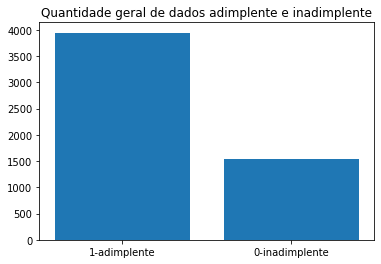

In [ ]:
df_ID_Bom = df[df['IND_BOM']== 1]
df_ID_Ruim = df[df['IND_BOM']== 0]

print("Adimplente =",len(df_ID_Bom))
print("Inadimplente =",len(df_ID_Ruim))
value=[len(df_ID_Bom),len(df_ID_Ruim)]
value_in_x=['1-adimplente','0-inadimplente']
plt.bar(value_in_x,value)
plt.title("Quantidade geral de dados adimplente e inadimplente")

plt.show()

In [ ]:
3945/5496 #Majority learning

0.7177947598253275

Quantidade para treino y_train 4943 0.8998725650828326
Quantidade para treino X_train 4943 0.8998725650828326
Quantidade para teste y_test 550 0.1001274349171673
Quantidade para teste y_test 550 0.1001274349171673
1    3947
0    3943
Name: IND_BOM, dtype: int64 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



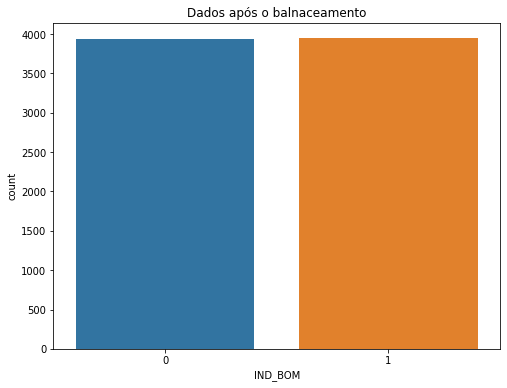

In [ ]:
# Dividindo e padronizando o dataset original
X = df.drop('IND_BOM', axis=1) #dando drop da coluna IN_BOM dos dados
y = df['IND_BOM']              #separando todos os valores de y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) #Divide arrays ou matrizes em treino aleatório e subconjuntos de teste

print("Quantidade para treino y_train",len(y_train),len(y_train)/len(df))
print("Quantidade para treino X_train",len(X_train),len(X_train)/len(df))
print("Quantidade para teste y_test",len(y_test),len(y_test)/len(df))
print("Quantidade para teste y_test",len(X_test),len(X_test)/len(df))


scaler = StandardScaler() #StandardScaler executa a tarefa de padronização.
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)#O valor da media das colunas e' transformado em 0, e desvio padrão a 1.

# Criando o dataset balanceado
maioria = df[df['IND_BOM'] == 1]
minoria = df[df['IND_BOM'] == 0]


#função resample para criar um dataset balanceado
minoria_balanceada = resample(minoria, replace=True, n_samples=3943)


credito_balanceado = pd.concat([maioria, minoria_balanceada])


# Dividindo e padronizando o dataset balanceado
X_balanceado = credito_balanceado.drop('IND_BOM', axis=1)
y_balanceado = credito_balanceado['IND_BOM']

X_train_balanceado, X_test_balanceado, y_train_balanceado, y_test_balanceado = train_test_split(X_balanceado, y_balanceado)

scaler_balanceado = StandardScaler()
scaler_balanceado.fit(X_train_balanceado)
X_train_balanceado = scaler_balanceado.transform(X_train_balanceado)
X_test_balanceado = scaler_balanceado.transform(X_test_balanceado)

# Verificando o balanceamento
print(credito_balanceado['IND_BOM'].value_counts(), '\n')

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(credito_balanceado['IND_BOM'])
ax.set_title('Dados após o balnaceamento')
plt.show()






## Aplicando 3 algoritmos de Machine Learning



*   xgboost
*   Regressão logística
*   Florestas aleatórias



In [ ]:
xgb = cross_validate(XGBClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
logreg = cross_validate(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
forest = cross_validate(RandomForestClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
forest_balanceado  = cross_validate(RandomForestClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
logreg_balanceado  = cross_validate(LogisticRegression(solver='liblinear'), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
xgb_balanceado  = cross_validate(XGBClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

In [ ]:
summary = pd.DataFrame({'labels': ['accuracy', 'precision', 'recall', 'roc_auc'],'xgb': [xgb['test_accuracy'].mean(), xgb['test_precision'].mean(), xgb['test_recall'].mean(), xgb['test_roc_auc'].mean()]           
,'logreg': [logreg['test_accuracy'].mean(), logreg['test_precision'].mean(), logreg['test_recall'].mean(), logreg['test_roc_auc'].mean()],'forest': [forest['test_accuracy'].mean(), forest['test_precision'].mean(), forest['test_recall'].mean(), forest['test_roc_auc'].mean()],'xgb_balanceado': [xgb_balanceado['test_accuracy'].mean(), xgb_balanceado['test_precision'].mean(), xgb_balanceado['test_recall'].mean(), xgb_balanceado['test_roc_auc'].mean()],'logreg_balanceado': [logreg_balanceado['test_accuracy'].mean(), logreg_balanceado['test_precision'].mean(), logreg_balanceado['test_recall'].mean(), logreg_balanceado['test_roc_auc'].mean()],'forest_balanceado': [forest_balanceado['test_accuracy'].mean(), forest_balanceado['test_precision'].mean(), forest_balanceado['test_recall'].mean(), forest_balanceado['test_roc_auc'].mean()]}).set_index('labels')
summary.index.name=None
summary = summary.transpose()    
summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.75 else '')

,accuracy,precision,recall,roc_auc
xgb,0.761278,0.784140,0.922101,0.753862
logreg,0.755815,0.778425,0.923506,0.754503
forest,0.747722,0.781170,0.902131,0.727813
xgb_balanceado,0.702716,0.706253,0.701273,0.779800
logreg_balanceado,0.688690,0.691254,0.689177,0.751285
forest_balanceado,0.849246,0.890631,0.798384,0.939386



![](https://drive.google.com/uc?export=view&id=1VHv_hn2K7tsqv8ADhznk3Z9o0IKEQXMJ)



##Random Forest

In [ ]:
modelo = RandomForestClassifier()
modelo.fit(X_train_balanceado, y_train_balanceado)

y_pred = modelo.predict(X_test_balanceado)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1002
           1       0.90      0.81      0.85       971

    accuracy                           0.86      1973
   macro avg       0.86      0.86      0.86      1973
weighted avg       0.86      0.86      0.86      1973

ROC_AUC Score: 0.8577834033272281 



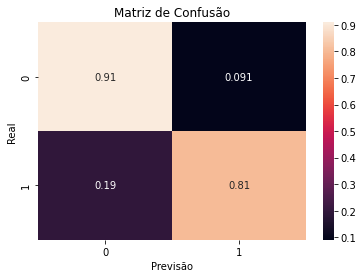

In [ ]:
print(classification_report(y_test_balanceado, y_pred))
print(f'ROC_AUC Score: {roc_auc_score(y_test_balanceado, y_pred)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_balanceado, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

In [ ]:
##Uma árvore é composta de nós, e esses nós são escolhidos procurando a divisão ideal dos recursos. Para isso, existem diferentes critérios. 
#critério '. Este parâmetro é a função usada para medir a qualidade de uma divisão e permite aos usuários escolher entre ' gini ' ou ' entropia '.
kfold = StratifiedKFold(n_splits=5, shuffle=True)

forest = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9362043631862662 para {'criterion': 'entropy'}


In [ ]:
#n_estimators,indica o número de árvores construídas pelo algoritmo antes de tomar uma votação ou fazer uma média de predições.
forest = RandomForestClassifier(criterion='entropy')

param_grid = {'n_estimators': range(50, 500, 50)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9368686844421992 para {'n_estimators': 400}


In [ ]:
modelo = RandomForestClassifier(criterion='entropy', n_estimators=400)
modelo.fit(X_train_balanceado, y_train_balanceado)

y_pred = modelo.predict(X_test_balanceado)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1002
           1       0.89      0.82      0.85       971

    accuracy                           0.86      1973
   macro avg       0.86      0.86      0.86      1973
weighted avg       0.86      0.86      0.86      1973

ROC_AUC Score: 0.8609367259302201 



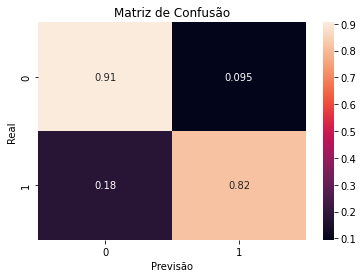

In [ ]:
print(classification_report(y_test_balanceado, y_pred))
print(f'ROC_AUC Score: {roc_auc_score(y_test_balanceado, y_pred)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_balanceado, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

## Teste final

In [ ]:
path_final = "/content/drive/MyDrive/Digio test/df1_final.csv"
df_final = pd.read_csv(path_final,sep = ',')
df_final

,Unnamed: 0,IDADE,GENERO,RENDA,SCORE_F1,SCORE_F2,IND_BOM,Regiao_0,Regiao_1,Regiao_2,Regiao_3,Regiao_4,Regiao_5,Regiao_6,Regiao_7,Regiao_8,Regiao_9
0,2773,24,0,20000,5600.0,4950.0,0,0,0,0,1,0,0,0,0,0,0
1,6079,43,0,26000,5800.0,6990.0,1,0,0,0,0,0,0,0,0,1,0
2,6085,39,0,50000,8590.0,8490.0,1,0,0,0,0,0,0,0,0,0,1
3,2836,51,0,77000,7810.0,7590.0,1,0,1,0,0,0,0,0,0,0,0
4,3166,45,1,350000,7640.0,7630.0,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,4168,25,0,31100,8420.0,7140.0,1,0,1,0,0,0,0,0,0,0,0
609,3304,21,0,20000,6270.0,7110.0,1,1,0,0,0,0,0,0,0,0,0
610,1038,25,1,20000,6820.0,5890.0,1,0,0,0,0,0,0,1,0,0,0
611,1668,30,1,13000,7890.0,6730.0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_final

array([[-1.19659965, -0.8236735 , -0.34549806, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [ 0.584456  , -0.8236735 , -0.29669721, ..., -0.31453594,
         2.80328788, -0.25238266],
       [ 0.20949691, -0.8236735 , -0.10149382, ..., -0.31453594,
        -0.35672398,  3.96223729],
       ...,
       [-1.10285987,  1.2140733 , -0.34549806, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [-0.63416102,  1.2140733 , -0.40243238, ..., -0.31453594,
         2.80328788, -0.25238266],
       [-0.35294171, -0.8236735 , -0.11776077, ..., -0.31453594,
        -0.35672398, -0.25238266]])

In [ ]:
X_final = df_final.drop(['IND_BOM','Unnamed: 0'], axis=1) #dando drop da coluna IN_BOM dos dados
y_final = df_final['IND_BOM']

In [ ]:
#StandardScaler executa a tarefa de padronização.
X_final = scaler.transform(X_final)
X_final

array([[-1.19659965, -0.8236735 , -0.34549806, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [ 0.584456  , -0.8236735 , -0.29669721, ..., -0.31453594,
         2.80328788, -0.25238266],
       [ 0.20949691, -0.8236735 , -0.10149382, ..., -0.31453594,
        -0.35672398,  3.96223729],
       ...,
       [-1.10285987,  1.2140733 , -0.34549806, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [-0.63416102,  1.2140733 , -0.40243238, ..., -0.31453594,
         2.80328788, -0.25238266],
       [-0.35294171, -0.8236735 , -0.11776077, ..., -0.31453594,
        -0.35672398, -0.25238266]])

              precision    recall  f1-score   support

           0       0.50      0.58      0.54       178
           1       0.82      0.76      0.79       435

    accuracy                           0.71       613
   macro avg       0.66      0.67      0.66       613
weighted avg       0.73      0.71      0.72       613

ROC_AUC Score: 0.673744026862973 



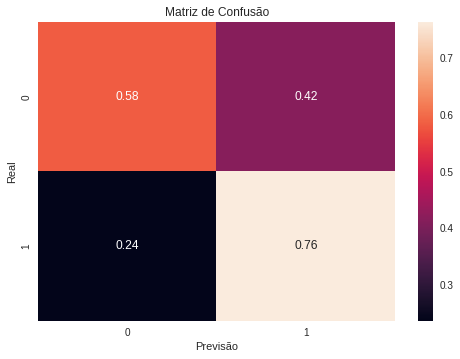

In [ ]:
y_pred_final = modelo.predict(X_final)
print(classification_report(y_final, y_pred_final))
print(f'ROC_AUC Score: {roc_auc_score(y_final, y_pred_final)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_final, y_pred_final, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(y_final, y_pred_final)

0.7161500815660685

##Logistc Regression 

In [ ]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

              precision    recall  f1-score   support

           0       0.53      0.30      0.38       159
           1       0.76      0.89      0.82       391

    accuracy                           0.72       550
   macro avg       0.64      0.59      0.60       550
weighted avg       0.69      0.72      0.69       550

ROC_AUC Score: 0.5940903022406666 



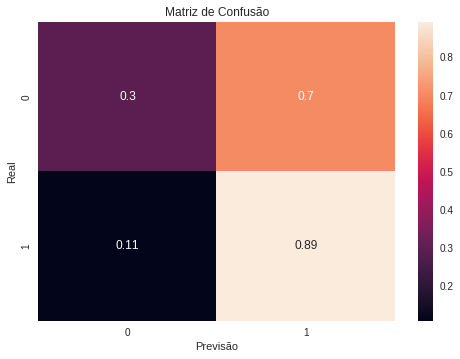

In [ ]:
print(classification_report(y_test, y_pred))
print(f'ROC_AUC Score: {roc_auc_score(y_test, y_pred)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

              precision    recall  f1-score   support

           0       0.60      0.38      0.47       178
           1       0.78      0.90      0.83       435

    accuracy                           0.75       613
   macro avg       0.69      0.64      0.65       613
weighted avg       0.73      0.75      0.73       613

ROC_AUC Score: 0.6392870980240217 



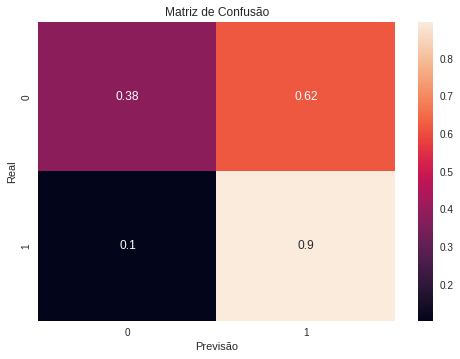

In [ ]:
y_pred_final = modelo.predict(X_final)
print(classification_report(y_final, y_pred_final))
print(f'ROC_AUC Score: {roc_auc_score(y_final, y_pred_final)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_final, y_pred_final, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(y_final, y_pred_final)

0.6639477977161501

##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
arvore_risco_credito = DecisionTreeClassifier(criterion='entropy')
arvore_risco_credito.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
arvore_risco_credito.feature_importances_

array([0.14497366, 0.02173839, 0.17418545, 0.23029338, 0.28614467,
       0.02224581, 0.01770597, 0.01044008, 0.02138634, 0.00883558,
       0.00918487, 0.01478674, 0.01213685, 0.01569864, 0.01024358])

In [ ]:
arvore_risco_credito.classes_

array([0, 1])

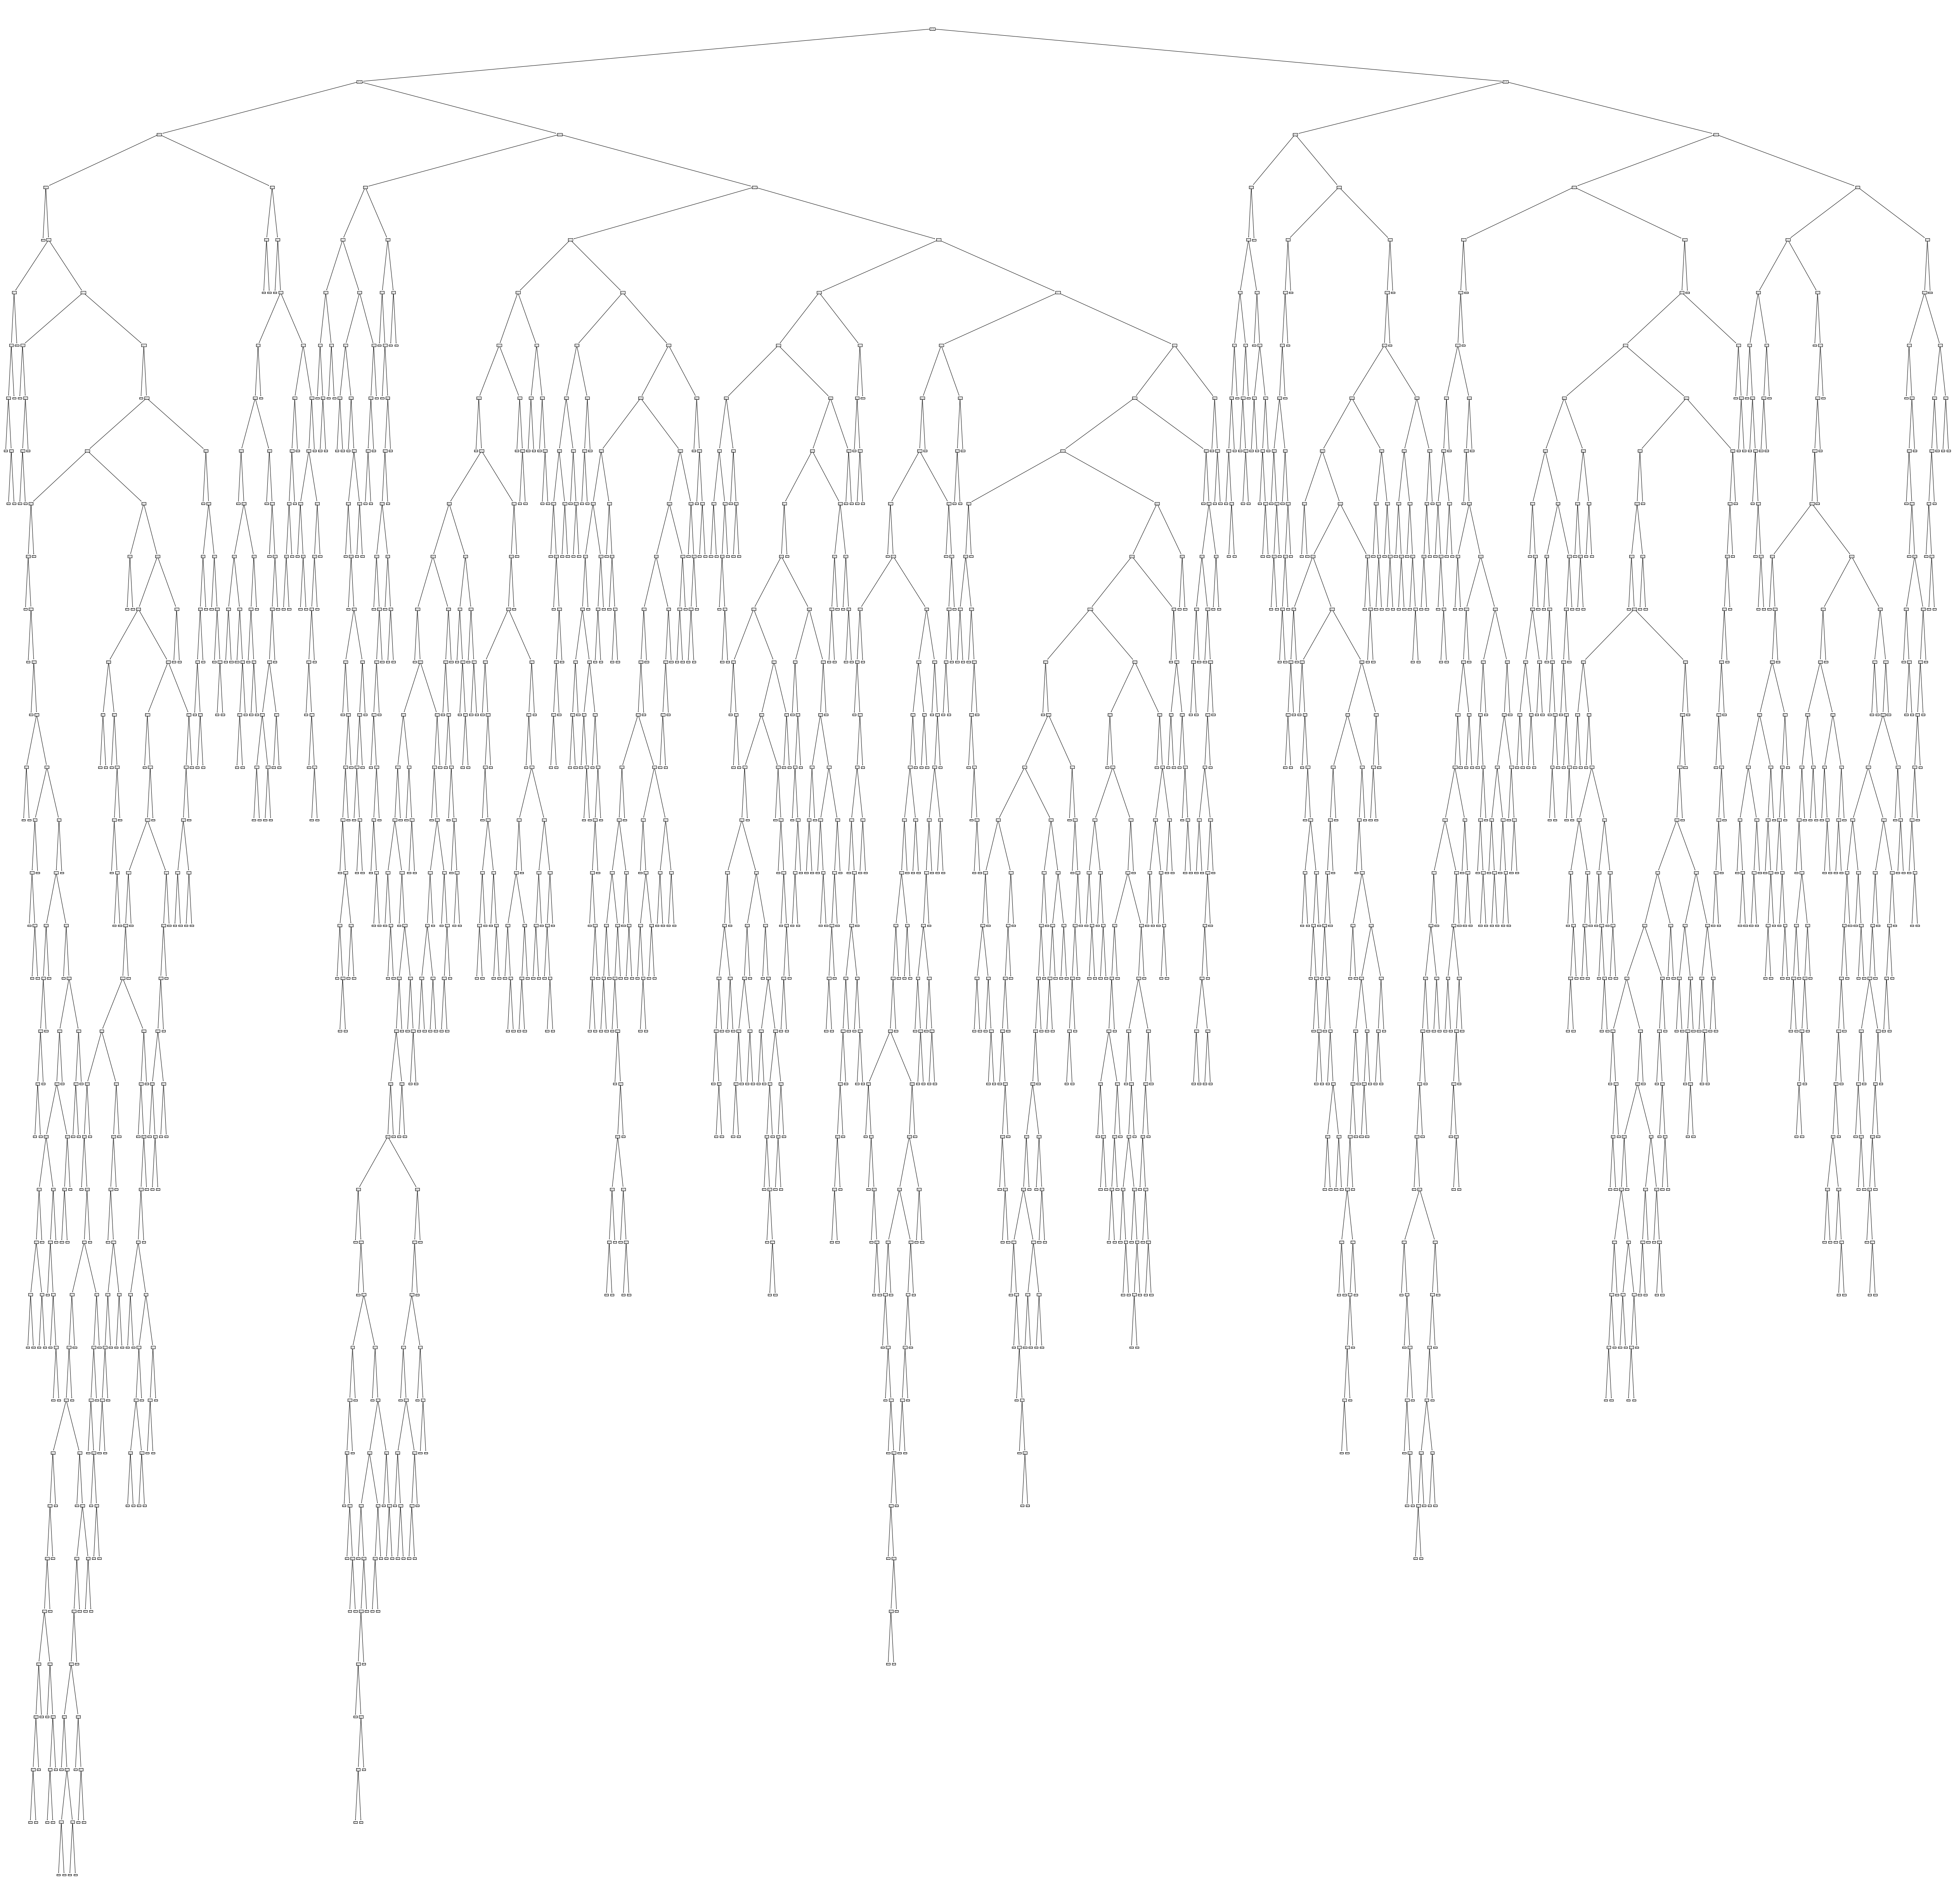

In [ ]:
from sklearn import tree
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(90,90))
tree.plot_tree(arvore_risco_credito);

In [ ]:
previsoes = arvore_risco_credito.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy_score(y_test, previsoes)

0.6509090909090909

In [ ]:
previsoes2 = arvore_risco_credito.predict(X_final)

In [ ]:
accuracy_score(y_final, previsoes2)

0.6704730831973899

              precision    recall  f1-score   support

           0       0.44      0.47      0.45       178
           1       0.78      0.75      0.76       435

    accuracy                           0.67       613
   macro avg       0.61      0.61      0.61       613
weighted avg       0.68      0.67      0.67       613

ROC_AUC Score: 0.6118171251452925 



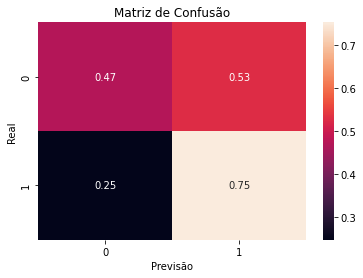

In [ ]:
print(classification_report(y_final, previsoes2))
print(f'ROC_AUC Score: {roc_auc_score(y_final, previsoes2)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_final, previsoes2, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

##Random Forest for unbalanced data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train

array([[ 0.86567531,  1.2140733 , -0.22349594, ..., -0.31453594,
         2.80328788, -0.25238266],
       [ 1.70933324, -0.8236735 , -0.26416331, ..., -0.31453594,
         2.80328788, -0.25238266],
       [-1.10285987, -0.8236735 , -0.19909551, ..., -0.31453594,
        -0.35672398, -0.25238266],
       ...,
       [ 0.02201737,  1.2140733 , -0.14216119, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [-0.82164056,  1.2140733 , -0.18282857, ...,  3.1792869 ,
        -0.35672398, -0.25238266],
       [ 1.33437416,  1.2140733 ,  0.06117568, ..., -0.31453594,
        -0.35672398, -0.25238266]])

In [ ]:
y_train

5583    1
5430    0
4846    0
72      1
6054    1
       ..
3141    1
4418    1
3291    1
1056    1
2334    1
Name: IND_BOM, Length: 4943, dtype: int64

In [ ]:
random_forest_census = RandomForestClassifier(n_estimators=400, criterion='entropy', random_state = 0)
random_forest_census.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
previsoes = random_forest_census.predict(X_test)

In [ ]:
accuracy_score(y_test, previsoes)

0.730909090909091

In [ ]:
previsoes2 = random_forest_census.predict(X_final)

In [ ]:
accuracy_score(y_final, previsoes2)

0.7520391517128875

              precision    recall  f1-score   support

           0       0.61      0.40      0.48       178
           1       0.78      0.90      0.84       435

    accuracy                           0.75       613
   macro avg       0.70      0.65      0.66       613
weighted avg       0.73      0.75      0.73       613

ROC_AUC Score: 0.6477140643161565 



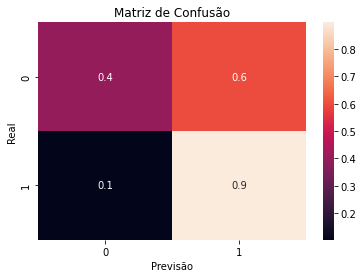

In [ ]:
print(classification_report(y_final, previsoes2))
print(f'ROC_AUC Score: {roc_auc_score(y_final, previsoes2)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_final, previsoes2, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

##KNN :(k- nearest neighbors)





In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_credit = KNeighborsClassifier(n_neighbors=55, metric='minkowski', p = 2)
knn_credit.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=55, p=2,
                     weights='uniform')

In [ ]:
previsoes = knn_credit.predict(X_test)
previsoes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
y_test

2305    0
5506    1
1780    1
781     1
4668    1
       ..
2146    1
2536    1
2703    1
933     1
6180    0
Name: IND_BOM, Length: 550, dtype: int64

In [ ]:
accuracy_score(y_test, previsoes)

0.7163636363636363

In [ ]:
previsoes = knn_credit.predict(X_final)
previsoes

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
accuracy_score(y_final, previsoes)

0.7357259380097879

In [ ]:
knn_credit = KNeighborsClassifier(n_neighbors=55, metric='minkowski', p = 2)
knn_credit.fit(X_train_balanceado, y_train_balanceado)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=55, p=2,
                     weights='uniform')

In [ ]:
previsoes = knn_credit.predict(X_test_balanceado)


In [ ]:
accuracy_score(y_test_balanceado, previsoes)

0.6811961479979727

              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1002
           1       0.67      0.71      0.69       971

    accuracy                           0.68      1973
   macro avg       0.68      0.68      0.68      1973
weighted avg       0.68      0.68      0.68      1973

ROC_AUC Score: 0.6816351848311616 



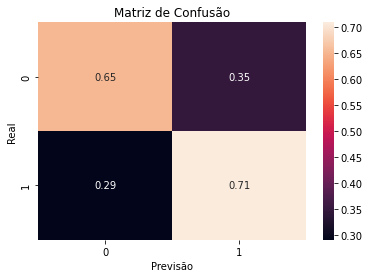

In [ ]:
print(classification_report(y_test_balanceado, previsoes))
print(f'ROC_AUC Score: {roc_auc_score(y_test_balanceado, previsoes)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_balanceado, previsoes, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

In [ ]:
previsoes = knn_credit.predict(X_final)

In [ ]:
accuracy_score(y_final, previsoes)

0.6590538336052202

              precision    recall  f1-score   support

           0       0.44      0.70      0.54       178
           1       0.84      0.64      0.73       435

    accuracy                           0.66       613
   macro avg       0.64      0.67      0.64       613
weighted avg       0.73      0.66      0.67       613

ROC_AUC Score: 0.6718132506780318 



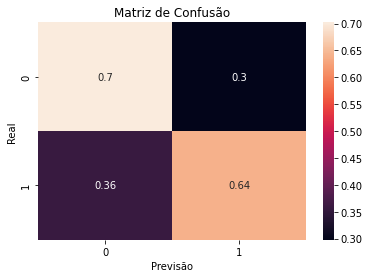

In [ ]:
print(classification_report(y_final, previsoes))
print(f'ROC_AUC Score: {roc_auc_score(y_final, previsoes)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_final, previsoes, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

##Support Vector Machines

In [ ]:
from sklearn.svm import SVC

![](https://drive.google.com/uc?export=view&id=1QooHLTts-qc6wt5Uwt0n63lHCF34a2i1)


![](https://drive.google.com/uc?export=view&id=12wfPfyB-1XujqcYL8QonbSbX26fn-O0T)



![](https://drive.google.com/uc?export=view&id=1l6-bO1aqC6sHQfgWgjjCn9N55Hd0yOZT)


##unbalanced data

kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

In [ ]:
svm_credit = SVC(kernel='rbf', random_state=1, C = 2.0) # 2 -> 4
svm_credit.fit(X_train, y_train)

SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
previsoes = svm_credit.predict(X_test)
previsoes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_test, previsoes)

0.7472727272727273

              precision    recall  f1-score   support

           0       0.67      0.25      0.36       159
           1       0.76      0.95      0.84       391

    accuracy                           0.75       550
   macro avg       0.71      0.60      0.60       550
weighted avg       0.73      0.75      0.70       550

ROC_AUC Score: 0.5983448342421464 



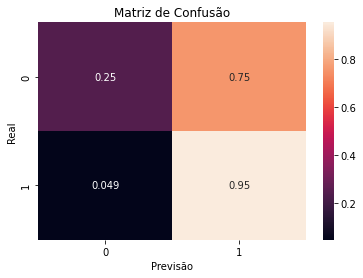

In [ ]:
print(classification_report(y_test, previsoes))
print(f'ROC_AUC Score: {roc_auc_score(y_test, previsoes)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, previsoes, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

##balanced data

kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

In [ ]:
svm_credit = SVC(kernel='rbf', random_state=1, C = 150.0) # 2 -> 4
svm_credit.fit(X_train_balanceado, y_train_balanceado)

SVC(C=150.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
previsoes = svm_credit.predict(X_test_balanceado)

In [ ]:
accuracy_score(y_test_balanceado, previsoes)

0.7237709072478459

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1002
           1       0.72      0.72      0.72       971

    accuracy                           0.72      1973
   macro avg       0.72      0.72      0.72      1973
weighted avg       0.72      0.72      0.72      1973

ROC_AUC Score: 0.7237743873735536 



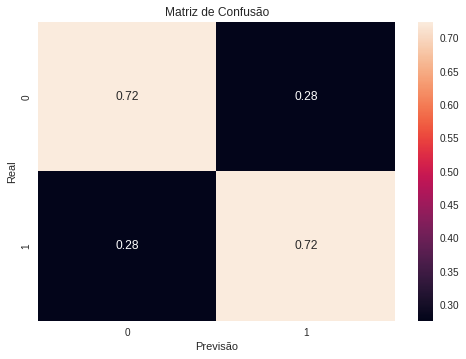

In [ ]:
print(classification_report(y_test_balanceado, previsoes))
print(f'ROC_AUC Score: {roc_auc_score(y_test_balanceado, previsoes)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_balanceado, previsoes, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

In [ ]:
X_final

array([[-1.19659965, -0.8236735 , -0.34549806, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [ 0.584456  , -0.8236735 , -0.29669721, ..., -0.31453594,
         2.80328788, -0.25238266],
       [ 0.20949691, -0.8236735 , -0.10149382, ..., -0.31453594,
        -0.35672398,  3.96223729],
       ...,
       [-1.10285987,  1.2140733 , -0.34549806, ..., -0.31453594,
        -0.35672398, -0.25238266],
       [-0.63416102,  1.2140733 , -0.40243238, ..., -0.31453594,
         2.80328788, -0.25238266],
       [-0.35294171, -0.8236735 , -0.11776077, ..., -0.31453594,
        -0.35672398, -0.25238266]])

In [ ]:
previsoes = svm_credit.predict(X_final)

In [ ]:
accuracy_score(y_final, previsoes)

0.6655791190864601

              precision    recall  f1-score   support

           0       0.45      0.69      0.55       178
           1       0.84      0.66      0.74       435

    accuracy                           0.67       613
   macro avg       0.64      0.67      0.64       613
weighted avg       0.73      0.67      0.68       613

ROC_AUC Score: 0.6730918248740798 



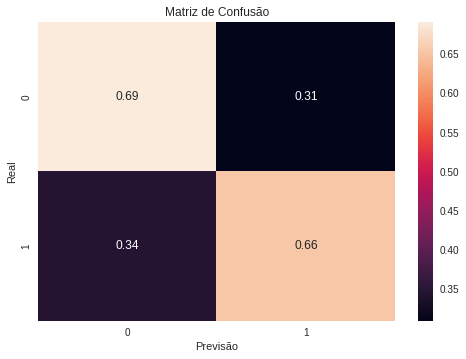

In [ ]:
print(classification_report(y_final, previsoes))
print(f'ROC_AUC Score: {roc_auc_score(y_final, previsoes)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_final, previsoes, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()